In [27]:
import numpy as np
import pandas as pd
import xarray as xr

import os
from glob import glob

import matplotlib.pyplot as plt

import histlib.matchup as match
import histlib.diagnosis as diag
from histlib.cstes import labels, zarr_dir, matchup_dir, var2, var, c0, c1
from histlib.matchup import _data_var, _stress_var, _aviso_var
from  histlib.diagnosis import global_ms_drifter_sat_year, compute_sum_ms, nMSRe_id, C_x, true_err_x, plot_closure_bar, plot_cor_uncor_part

from xhistogram.xarray import histogram


import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo
crs = ccrs.PlateCarree()
import cmocean.cm as cm


In [ ]:
zarr_dir

## IMPORT DATA, build dataset
We choose to get only erastar wind term, and we reject PEACHY data, and we select only deltaT<1H

In [4]:
id_aviso = 'aviso__25__adt__es_cstrio_z15__alti_x'
id_aviso_drifter = 'aviso__25__adt__es_cstrio_z15__drifter_x'
id_co = 'co__25__adt_filtered_ocean_tide_internal_tide__es_cstrio_z15__alti_x'
id_aviso_drifter_dic =  {'acc':'drifter_acc_x_25','coriolis':'drifter_coriolis_x_25','ggrad':'aviso_drifter_ggx_adt','wind':'es_cstrio_z15_drifter_wd_x'}
id_co_dic =  {'acc':'drifter_acc_x_25','coriolis':'drifter_coriolis_x_25','ggrad':'alti_ggx_adt_filtered_ocean_tide_internal_tide','wind':'es_cstrio_z15_alti_wd_x'}
id_aviso_dic =  {'acc':'drifter_acc_x_25','coriolis':'drifter_coriolis_x_25','ggrad':'aviso_alti_ggx_adt','wind':'es_cstrio_z15_alti_wd_x'}

In [12]:
def global_disttime_ms_drifter_sat_year(dsms):
    ds = (((dsms*dsms.nb_coloc_bin).sum('drifter_sat_year'))/(dsms.nb_coloc_bin.sum('drifter_sat_year'))).drop('nb_coloc_bin')
    ds['nb_coloc_bin']=dsms.nb_coloc_bin.sum('drifter_sat_year')
    return ds

In [5]:
dl = 5
dt = 10*60

_____________
# Covariance

In [124]:
#ftime = glob(os.path.join(zarr_dir+'_ok',f'mstime/mstime_{int(dt)}_drogued_*.zarr'))
#ftime = [f for f in ftime if 'gps' in f]
fdist = glob(os.path.join(zarr_dir+'_ok',f'corrdist/corrdist_{int(dl)}_drogued_*.zarr'))
fdist = [f for f in fdist if 'gps' in f]
#dst_ = xr.concat([xr.open_dataset(f) for f in ftime], dim='drifter_sat_year')
dsd_ = xr.concat([xr.open_dataset(f) for f in fdist], dim='drifter_sat_year')

In [125]:
#dst = global_disttime_ms_drifter_sat_year(dst_)
dsdc = global_disttime_ms_drifter_sat_year(dsd_)
dsdc['distbin']=dsdc['distbin']/1000
#dst['timebin']=dst['timebin']/3600

In [217]:
def exp_decay(dx, dx_constant, amplitude, cst):
    return np.exp(-dx / dx_constant) * amplitude +cst

cor_alg = -dsdc.prod_drifter_coriolis_x_25__alti_ggx_adt_filtered_ocean_tide_internal_tide
acc_alg = -dsdc.prod_drifter_acc_x_25__alti_ggx_adt_filtered_ocean_tide_internal_tide
cor_av = -dsdc.prod_drifter_coriolis_x_25__aviso_alti_ggx_adt
acc_av = -dsdc.prod_drifter_acc_x_25__aviso_alti_ggx_adt
cor_av_d = -dsdc.prod_drifter_coriolis_x_25__aviso_drifter_ggx_adt
acc_av_d = -dsdc.prod_drifter_acc_x_25__aviso_drifter_ggx_adt
cor_wd_alti = -dsdc.prod_drifter_coriolis_x_25__es_cstrio_z15_alti_wd_x
cor_wd_drifter = -dsdc.prod_drifter_coriolis_x_25__es_cstrio_z15_drifter_wd_x

fit_cor_alg = cor_alg.curvefit("distbin", exp_decay)
fit_acc_alg = acc_alg.curvefit("distbin", exp_decay)
fit_cor_av = cor_av.curvefit("distbin", exp_decay)
fit_acc_av = acc_av.curvefit("distbin", exp_decay)
fit_cor_wd = cor_wd_alg.curvefit("distbin", exp_decay)

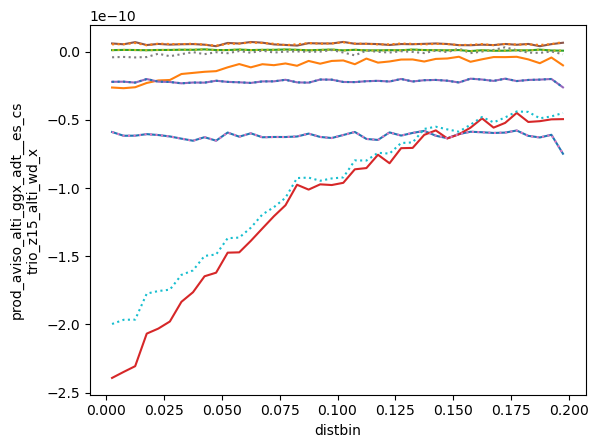

In [81]:
import itertools
corr_key_co = list(itertools.combinations(list(id_co_dic.values()),2))
corr_key_av = list(itertools.combinations(list(id_aviso_dic.values()),2)) 
corr_var_co = ["prod_"+ab[0]+"__"+ab[1] for ab in corr_key_co]
corr_var_aviso = ["prod_"+ab[0]+"__"+ab[1] for ab in corr_key_av]

for v in corr_var_co :
    dsdc[v].plot(label=v)
for v in corr_var_aviso :
    dsdc[v].plot(label=v, ls=':')
#plt.legend()

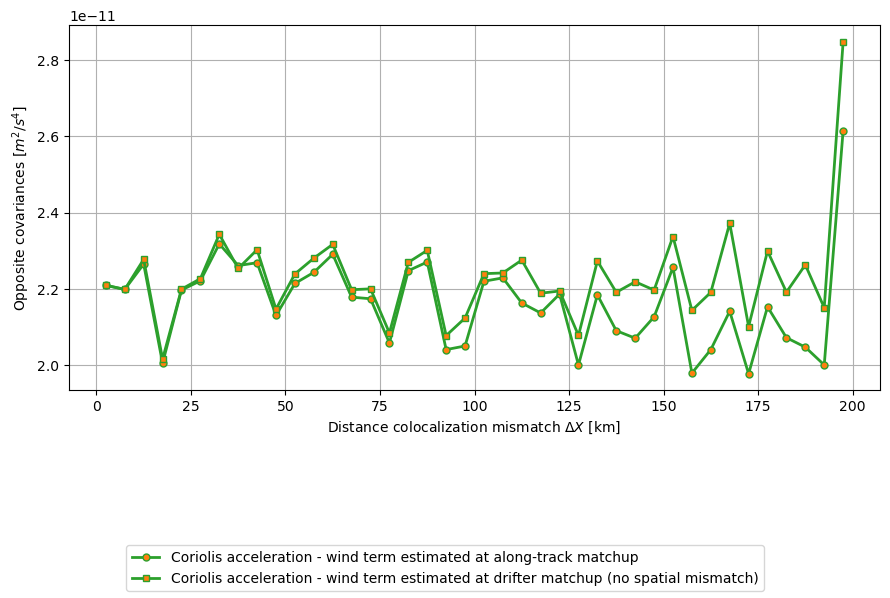

In [218]:
fig, ax = plt.subplots(1,1, figsize=(9,6))

cor_wd_alti.plot(c = c0['coriolis'], marker = 'o', markerfacecolor=c0['wind'], markersize=5, lw=2, label= 'Coriolis acceleration - wind term estimated at along-track matchup')
cor_wd_drifter.plot(c = c0['coriolis'], marker = 's', markerfacecolor=c0['wind'], markersize=5, lw=2, label= 'Coriolis acceleration - wind term estimated at drifter matchup (no spatial mismatch)')

ax.grid()
ax.set_ylabel('Opposite covariances $[m^2/s^4]$')
ax.set_xlabel('Distance colocalization mismatch $\Delta X$ [km]')

fig.legend(ncol=1,loc='lower center')#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.24,1,1])#left, bottom, right, top (default is 0,0,1,1)

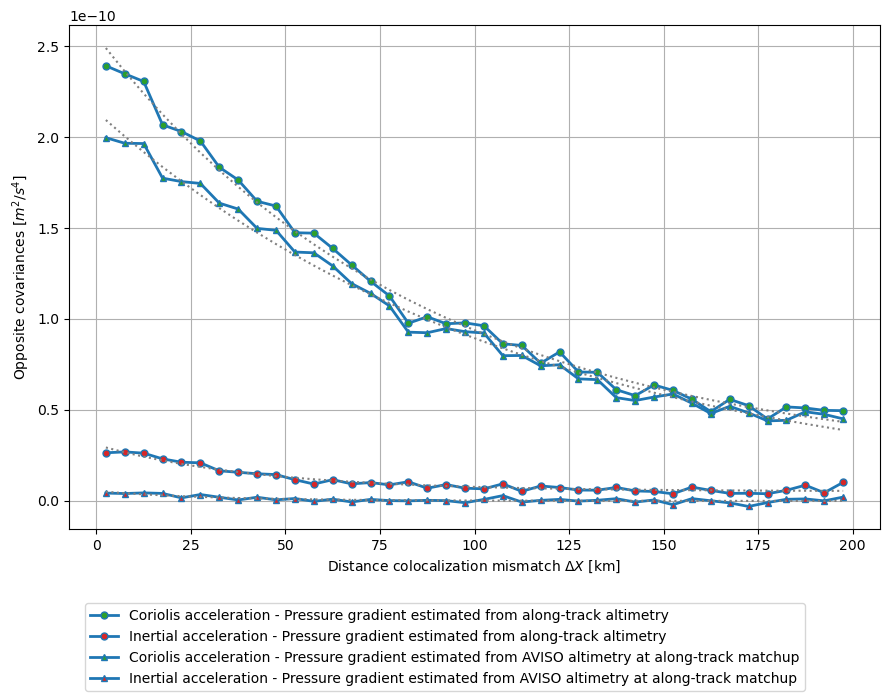

In [175]:
fig, ax = plt.subplots(1,1, figsize=(9,7))

cor_wd_alg.plot(c = c0['ggrad'], marker = 'o', markerfacecolor=c0['coriolis'], markersize=5, lw=2, label= 'Coriolis acceleration - Pressure gradient estimated from along-track altimetry')
acc_alg.plot(c = c0['ggrad'], marker = 'o', markerfacecolor=c0['acc'], markersize=5, lw=2, label= 'Inertial acceleration - Pressure gradient estimated from along-track altimetry')


exp_decay(cor_alg.distbin, *fit_cor_alg.curvefit_coefficients).plot(ls=':', c='grey')
exp_decay(acc_alg.distbin, *fit_acc_alg.curvefit_coefficients).plot(ls=':', c='grey')
exp_decay(cor_av.distbin, *fit_cor_av.curvefit_coefficients).plot(ls=':', c='grey')
exp_decay(acc_av.distbin, *fit_acc_av.curvefit_coefficients).plot(ls=':', c='grey')

ax.grid()
ax.set_ylabel('Opposite covariances $[m^2/s^4]$')
ax.set_xlabel('Distance colocalization mismatch $\Delta X$ [km]')
ax.set_title('')

fig.legend(ncol=1,loc='lower center')#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.15,1,1])#left, bottom, right, top (default is 0,0,1,1)

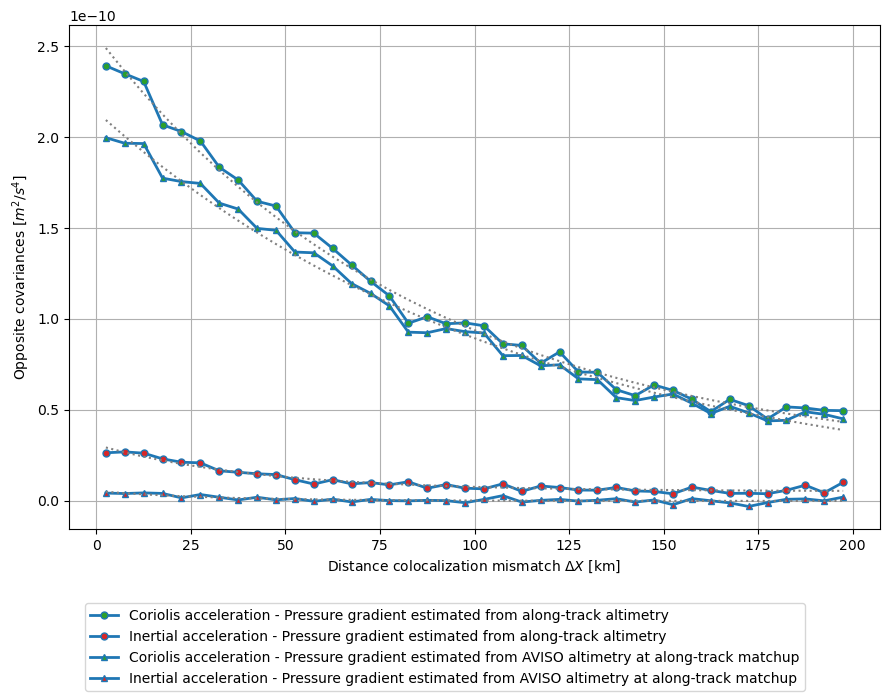

In [175]:
fig, ax = plt.subplots(1,1, figsize=(9,7))

cor_alg.plot(c = c0['ggrad'], marker = 'o', markerfacecolor=c0['coriolis'], markersize=5, lw=2, label= 'Coriolis acceleration - Pressure gradient estimated from along-track altimetry')
acc_alg.plot(c = c0['ggrad'], marker = 'o', markerfacecolor=c0['acc'], markersize=5, lw=2, label= 'Inertial acceleration - Pressure gradient estimated from along-track altimetry')
cor_av.plot(c = c0['ggrad'], marker = '^', markerfacecolor=c0['coriolis'], markersize=4, lw=2, label= 'Coriolis acceleration - Pressure gradient estimated from AVISO altimetry at along-track matchup')
acc_av.plot(c = c0['ggrad'], marker = '^', markerfacecolor=c0['acc'], markersize=4, lw=2, label= 'Inertial acceleration - Pressure gradient estimated from AVISO altimetry at along-track matchup')


exp_decay(cor_alg.distbin, *fit_cor_alg.curvefit_coefficients).plot(ls=':', c='grey')
exp_decay(acc_alg.distbin, *fit_acc_alg.curvefit_coefficients).plot(ls=':', c='grey')
exp_decay(cor_av.distbin, *fit_cor_av.curvefit_coefficients).plot(ls=':', c='grey')
exp_decay(acc_av.distbin, *fit_acc_av.curvefit_coefficients).plot(ls=':', c='grey')

ax.grid()
ax.set_ylabel('Opposite covariances $[m^2/s^4]$')
ax.set_xlabel('Distance colocalization mismatch $\Delta X$ [km]')
ax.set_title('')

fig.legend(ncol=1,loc='lower center')#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.15,1,1])#left, bottom, right, top (default is 0,0,1,1)

In [216]:
for da in [fit_cor_alg, fit_acc_alg, fit_cor_av, fit_acc_av, fit_cor_wd]:
    dx = da.sel(param="dx_constant").curvefit_coefficients.values
    errdx = np.sqrt(da.sel(cov_i="dx_constant", cov_j="dx_constant").curvefit_covariance).values
    print(f'{np.rint(dx)} pm {np.ceil(errdx)}')

87.0 pm 5.0
43.0 pm 5.0
113.0 pm 9.0
31.0 pm 10.0
145.0 pm 503.0


______________________
# Exponential fit


_____________
# MS

In [128]:
#ftime = glob(os.path.join(zarr_dir+'_ok',f'mstime/mstime_{int(dt)}_drogued_*.zarr'))
#ftime = [f for f in ftime if 'gps' in f]
fdist = glob(os.path.join(zarr_dir+'_ok',f'msdist/msdist_{int(dl)}_drogued_*.zarr'))
fdist = [f for f in fdist if 'gps' in f]
#dst_ = xr.concat([xr.open_dataset(f) for f in ftime], dim='drifter_sat_year')
dsd_ = xr.concat([xr.open_dataset(f) for f in fdist], dim='drifter_sat_year')

In [129]:
#dst = global_disttime_ms_drifter_sat_year(dst_)
dsd = global_disttime_ms_drifter_sat_year(dsd_)
dsd['distbin']=dsd['distbin']/1000
#dst['timebin']=dst['timebin']/3600

"\nfig, axs = plt.subplots(2,1, figsize=(6,7))\nax = axs[0]\ndst['sum_'+id_co].plot(label='Along-track', ax=ax, c='teal')\ndst['sum_'+id_aviso].plot(label='AVISO along-track matchup', ax=ax, c='salmon')\ndst['sum_'+id_aviso_drifter].plot(label='AVISO drifter matchup', ax=ax, c='red')\nax.grid()\nax.legend()\nax.set_xlabel(r'Time gap $DT$ [h]')\nax.set_ylabel(r'$\\langle S^2 \rangle [m^2/s^4]$')\n\n\nax = axs[1]\n(dst['sum_'+id_co]/compute_sum_ms(dst, id_co, id_co_dic)*100).plot(label='Along-track', ax=ax, c='teal')\n(dst['sum_'+id_aviso]/compute_sum_ms(dst, id_aviso, id_aviso_dic)*100).plot(label='AVISO', ax=ax, c='salmon')\n(dst['sum_'+id_aviso_drifter]/compute_sum_ms(dst, id_aviso_drifter, id_aviso_drifter_dic)*100).plot(label='AVISO drifter matchup', ax=ax, c='red')\n#dsd['sum_'+id_aviso].plot(label='AVISO', ax=ax)\nax.set_xlabel(r'Time gap $DT$ [h]')\nax.set_ylabel('RSE [%]')\nax.grid()\n"

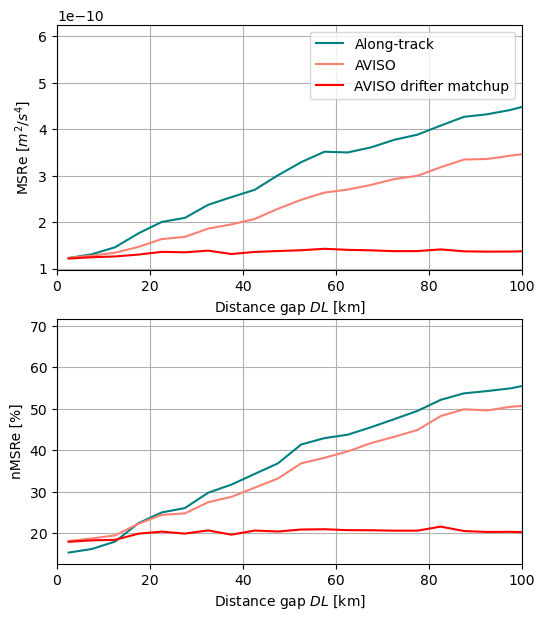

In [130]:
def compute_sum_ms(ds, id_, dic=None):
    if dic == None :
        dic = ds['sum_'+id_].attrs
    return ds[dic['acc']]+ds[dic['coriolis']]+ds[dic['ggrad']]+ds[dic['wind']]
    
fig, axs = plt.subplots(2,1, figsize=(6,7))
ax = axs[0]
dsd['sum_'+id_co].plot(label='Along-track', ax=ax, c='teal')
dsd['sum_'+id_aviso].plot(label='AVISO', ax=ax, c='salmon')
dsd['sum_'+id_aviso_drifter].plot(label='AVISO drifter matchup', ax=ax, c='red')
ax.grid()
ax.legend()
ax.set_xlabel(r'Distance gap $DL$ [km]')
ax.set_ylabel(r'MSRe $[m^2/s^4]$')
ax.set_xlim(0,100)
#ax.set_ylim(1.5e-10,5e-10)

ax = axs[1]
(dsd['sum_'+id_co]/compute_sum_ms(dsd, id_co, id_co_dic)*100).plot(label='Along-track', ax=ax, c='teal')
(dsd['sum_'+id_aviso]/compute_sum_ms(dsd, id_aviso, id_aviso_dic)*100).plot(label='AVISO', ax=ax, c='salmon')
(dsd['sum_'+id_aviso_drifter]/compute_sum_ms(dsd, id_aviso_drifter, id_aviso_drifter_dic)*100).plot(label='AVISO drifter matchup', ax=ax, c='red')
ax.set_xlabel(r'Distance gap $DL$ [km]')
ax.set_ylabel('nMSRe [%]')
ax.grid()
ax.set_xlim(0,100)
#ax.set_ylim(20, 63)
"""
fig, axs = plt.subplots(2,1, figsize=(6,7))
ax = axs[0]
dst['sum_'+id_co].plot(label='Along-track', ax=ax, c='teal')
dst['sum_'+id_aviso].plot(label='AVISO along-track matchup', ax=ax, c='salmon')
dst['sum_'+id_aviso_drifter].plot(label='AVISO drifter matchup', ax=ax, c='red')
ax.grid()
ax.legend()
ax.set_xlabel(r'Time gap $DT$ [h]')
ax.set_ylabel(r'$\langle S^2 \rangle [m^2/s^4]$')


ax = axs[1]
(dst['sum_'+id_co]/compute_sum_ms(dst, id_co, id_co_dic)*100).plot(label='Along-track', ax=ax, c='teal')
(dst['sum_'+id_aviso]/compute_sum_ms(dst, id_aviso, id_aviso_dic)*100).plot(label='AVISO', ax=ax, c='salmon')
(dst['sum_'+id_aviso_drifter]/compute_sum_ms(dst, id_aviso_drifter, id_aviso_drifter_dic)*100).plot(label='AVISO drifter matchup', ax=ax, c='red')
#dsd['sum_'+id_aviso].plot(label='AVISO', ax=ax)
ax.set_xlabel(r'Time gap $DT$ [h]')
ax.set_ylabel('RSE [%]')
ax.grid()
"""

(1e-10, 5e-10)

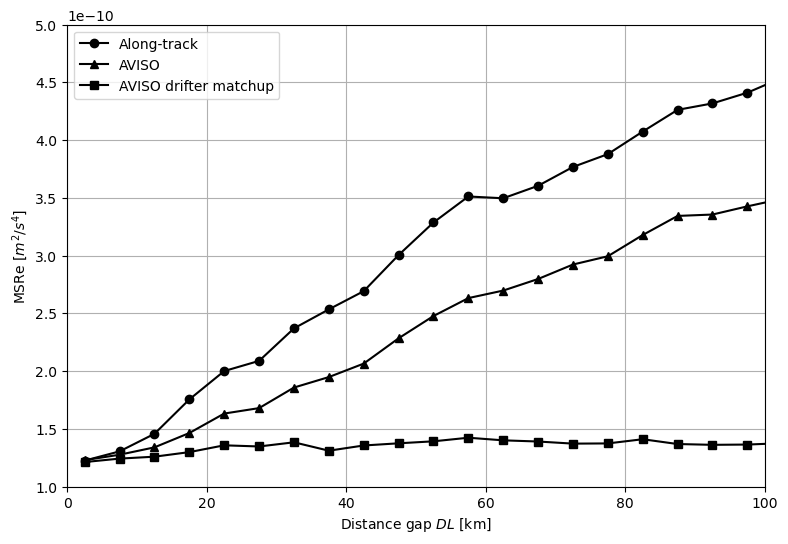

In [131]:
fig, ax = plt.subplots(1,1, figsize=(9,6))
dsd['sum_'+id_co].plot(label='Along-track', ax=ax, c='k', marker='o')
dsd['sum_'+id_aviso].plot(label='AVISO', ax=ax, c='k', marker='^')
dsd['sum_'+id_aviso_drifter].plot(label='AVISO drifter matchup', ax=ax, c='k', marker='s')
ax.grid()
ax.legend()
ax.set_xlabel(r'Distance gap $DL$ [km]')
ax.set_ylabel(r'MSRe $[m^2/s^4]$')
ax.set_xlim(0,100)
ax.set_ylim(1e-10,5e-10)

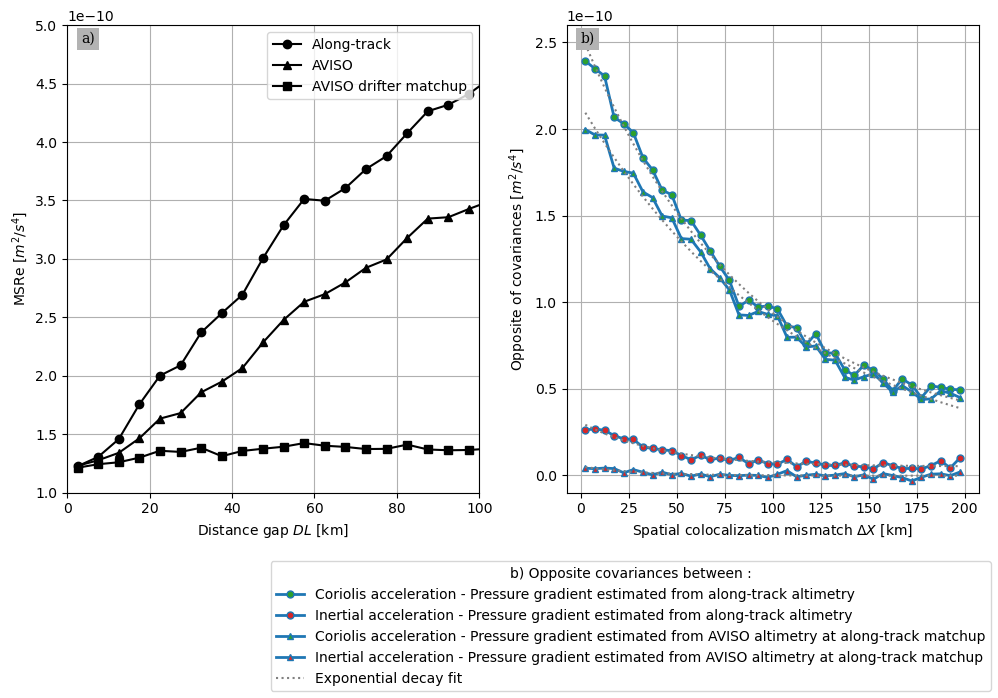

In [200]:
import matplotlib.transforms as mtransforms

fig, axs = plt.subplot_mosaic([['a)', 'b)']],layout='constrained', figsize=(10,7))

for label, ax in axs.items():
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))
    
ax =axs['a)']
dsd['sum_'+id_co].plot(label='Along-track', ax=ax, c='k', marker='o')
dsd['sum_'+id_aviso].plot(label='AVISO', ax=ax, c='k', marker='^')
dsd['sum_'+id_aviso_drifter].plot(label='AVISO drifter matchup', ax=ax, c='k', marker='s')
ax.grid()
ax.legend()
ax.set_xlabel(r'Distance gap $DL$ [km]')
ax.set_ylabel(r'MSRe $[m^2/s^4]$')
ax.set_xlim(0,100)
ax.set_ylim(1e-10,5e-10)
ax.legend(ncol=1, loc='upper right')#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,

ax =axs['b)']
cor_alg.plot(c = c0['ggrad'], marker = 'o', markerfacecolor=c0['coriolis'], markersize=5, lw=2, label= 'Coriolis acceleration - Pressure gradient estimated from along-track altimetry')
acc_alg.plot(c = c0['ggrad'], marker = 'o', markerfacecolor=c0['acc'], markersize=5, lw=2, label= 'Inertial acceleration - Pressure gradient estimated from along-track altimetry')
cor_av.plot(c = c0['ggrad'], marker = '^', markerfacecolor=c0['coriolis'], markersize=4, lw=2, label= 'Coriolis acceleration - Pressure gradient estimated from AVISO altimetry at along-track matchup')
acc_av.plot(c = c0['ggrad'], marker = '^', markerfacecolor=c0['acc'], markersize=4, lw=2, label= 'Inertial acceleration - Pressure gradient estimated from AVISO altimetry at along-track matchup')


exp_decay(cor_alg.distbin, *fit_cor_alg.curvefit_coefficients).plot(ls=':', c='grey', label = 'Exponential decay fit')
exp_decay(acc_alg.distbin, *fit_acc_alg.curvefit_coefficients).plot(ls=':', c='grey')
exp_decay(cor_av.distbin, *fit_cor_av.curvefit_coefficients).plot(ls=':', c='grey')
exp_decay(acc_av.distbin, *fit_acc_av.curvefit_coefficients).plot(ls=':', c='grey')

ax.grid()
ax.set_title('')
ax.set_ylabel('Opposite of covariances $[m^2/s^4]$')
ax.set_xlabel('Spatial colocalization mismatch $\Delta X$ [km]')
ax.set_ylim(-1e-11,2.6e-10)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, ncol=1,loc='lower right', title='b) Opposite covariances between :')#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.2,1,1])#left, bottom, right, top (default is 0,0,1,1)

______________________
# Colocalization error estimation


In [141]:
## IMPORT GLOBAL MS ESTIMATION
DL =25*1e3 #meters
DT = 1800.0 #seconds
dsms = xr.open_dataset(os.path.join(zarr_dir+'_ok','global',f'ms_{int(DL//1000)}_{DT}_drogued.zarr'))
gps = [l for l in dsms.drifter_sat_year.values if 'gps' in l]
dsmean = xr.open_dataset(os.path.join(zarr_dir+'_ok','global',f'mean_{int(DL//1000)}_{DT}_drogued.zarr'))

ds, mslow, msup = global_ms_drifter_sat_year(dsmean.sel(drifter_sat_year=gps), dsms.sel(drifter_sat_year=gps), alpha=0.01)
mserr = (msup-mslow)/2

<xarray.DataArray 'nb_coloc' ()>
array(146030)


In [148]:
print('Along-track : msre25km-mindistmsre/msre25km = ',((ds['sum_'+id_co]-dsd['sum_'+id_co].isel(distbin=0))/ds['sum_'+id_co]*100).values)
print('AVISO : msre25km-mindistmsre/msre25km = ',((ds['sum_'+id_aviso]-dsd['sum_'+id_aviso].isel(distbin=0))/ds['sum_'+id_aviso]*100).values)

Along-track : msre25km-mindistmsre/msre25km =  21.04026192165972
AVISO : msre25km-mindistmsre/msre25km =  11.584476413387163


In [149]:
print('Along-track : msre25km-mindistmsre = ',(ds['sum_'+id_co]-dsd['sum_'+id_co].isel(distbin=0)).values)
print('AVISO : msre25km-mindistmsre = ',(ds['sum_'+id_aviso]-dsd['sum_'+id_aviso].isel(distbin=0)).values)

Along-track : msre25km-mindistmsre =  3.267745859702327e-11
AVISO : msre25km-mindistmsre =  1.6115257908045492e-11


______________________
# Count


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


NameError: name 'dst' is not defined

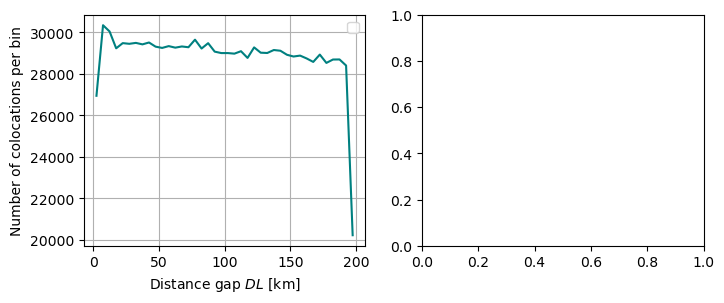

In [67]:
fig, axs = plt.subplots(1,2, figsize=(8,3))
ax = axs[0]
dsd.nb_coloc_bin.plot(ax=ax, c='teal')
ax.legend()
ax.grid()
ax.set_xlabel(r'Distance gap $DL$ [km]')
ax.set_ylabel('Number of colocations per bin')

ax = axs[1]
dst.nb_coloc_bin.plot(ax=ax, c='teal')
ax.legend()
ax.grid()
ax.set_xlabel(r'Time gap $DT$ [h]')
ax.set_ylabel('Number of colocations per bin')
fig.tight_layout()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


NameError: name 'dst' is not defined

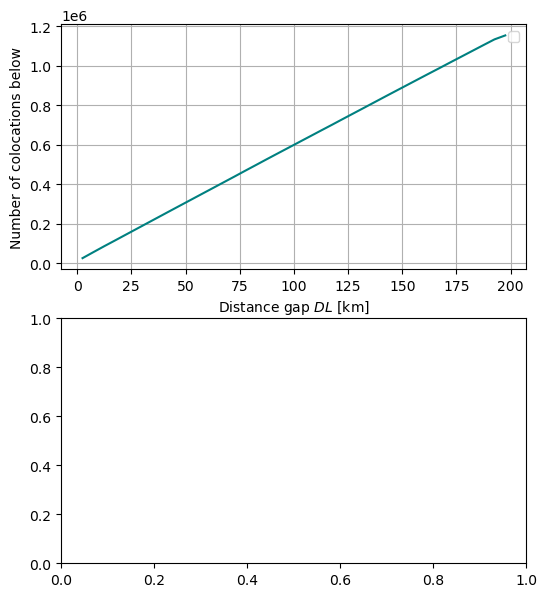

In [68]:
fig, axs = plt.subplots(2,1, figsize=(6,7))
ax = axs[0]
dsd.nb_coloc_bin.cumsum('distbin').plot(ax=ax, c='teal')
ax.legend()
ax.grid()
ax.set_xlabel(r'Distance gap $DL$ [km]')
ax.set_ylabel('Number of colocations below')

ax = axs[1]
dst.nb_coloc_bin.cumsum('timebin').plot(ax=ax, c='teal')
ax.legend()
ax.grid()
ax.set_xlabel(r'Time gap $DT$ [h]')
ax.set_ylabel('Number of colocations below')
fig.tight_layout()

______________________
# $x$ contribution : $C_{x_i} =\langle S_{-x_i}^2\rangle-\langle S^2 \rangle$  and $Rcn_{x_i} = \frac{\langle S_{-x_i}^2\rangle-\langle S^2 \rangle}{\sum_i \langle x_i^2 \rangle}$
## Under H1 :
$Rc_{x_i} = \frac{\langle \hat{x}^2 \rangle - \langle {x_i^{e}}^2\rangle}{\sum_i \langle x_i^2 \rangle}$  

 - $RC_{x_i}<0 \Leftrightarrow \langle \hat{x}^2 \rangle < \langle {x_i^{e}}^2\rangle$ more error than signal is added
 - $RC_{x_i}>0 \Leftrightarrow \langle \hat{x}^2 \rangle > \langle {x_i^{e}}^2\rangle$ more signal than error is added
 - The bigger $Rc_x$ is, the better closure we have
Results :
 - $RC_x$<0 for inertial acceleration and wind

In [31]:
def RC_x(ds, id_, dic=None):
    if isinstance(id_, str):
        lab = ['acc', 'coriolis', 'ggrad', 'wind']
        Rc_x = xr.Dataset()
        for l in lab :
            Rc_x[l] = (ds['exc_'+l+'_'+id_] - ds['sum_'+id_])
    return Rc_x
    
def RCn_x(ds, id_, dic=None):
    if isinstance(id_, str):
        lab = ['acc', 'coriolis', 'ggrad', 'wind']
        s = compute_sum_ms(ds, id_, dic)
        Rcn_x = xr.Dataset()
        for l in lab :
            Rcn_x[l] = (ds['exc_'+l+'_'+id_] - ds['sum_'+id_])/s
    return Rcn_x
    
RCXnd = xr.concat([RCn_x(dsd, id_co, dic = id_co_dic), RCn_x(dsd, id_aviso, dic = id_aviso_dic)], dim =pd.Index([id_co, id_aviso], name='id_comb')) 
#RCXnt = xr.concat([RCn_x(dst, id_co, dic = id_co_dic), RCn_x(dst, id_aviso, dic = id_aviso_dic)], dim =pd.Index([id_co, id_aviso], name='id_comb'))

RCXd = xr.concat([RC_x(dsd, id_co, dic = id_co_dic), RC_x(dsd, id_aviso, dic = id_aviso_dic)], dim =pd.Index([id_co, id_aviso], name='id_comb')) 
#RCXt = xr.concat([RC_x(dst, id_co, dic = id_co_dic), RC_x(dst, id_aviso, dic = id_aviso_dic)], dim =pd.Index([id_co, id_aviso], name='id_comb')) 

Text(0.5, 1.0, '')

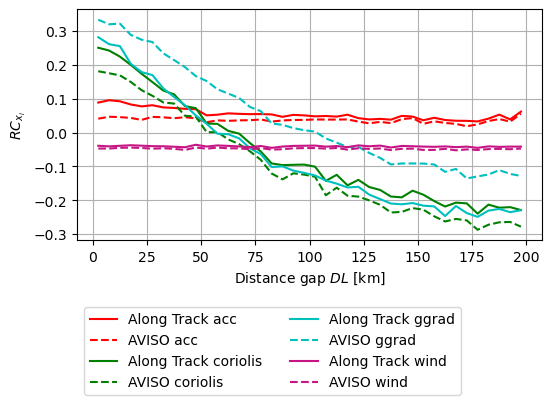

In [15]:

plt.figure(figsize=(6,3))
for v in ['acc', 'coriolis', 'ggrad', 'wind']:
    RCXnd.sel(id_comb=id_co)[v].plot(label='Along Track ' +v, color = term_color[v])
    RCXnd.sel(id_comb=id_aviso)[v].plot(label='AVISO ' +v, color = term_color[v], ls='--')
plt.legend(ncol = 2, bbox_to_anchor=(0, -0.7), loc='lower left')
plt.grid()
plt.xlabel(r'Distance gap $DL$ [km]')
plt.ylabel(r'$RC_{x_i}$')
plt.title('')


Text(0.5, 1.0, '')

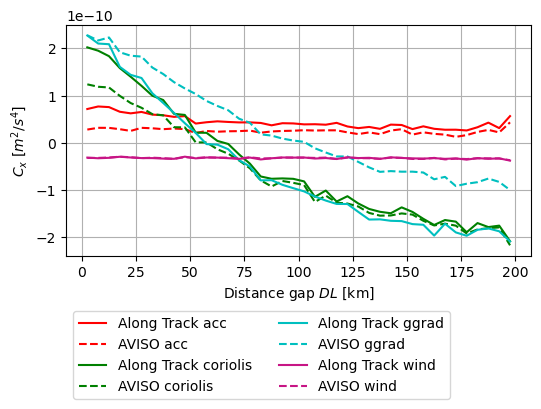

In [16]:

plt.figure(figsize=(6,3))
for v in ['acc', 'coriolis', 'ggrad', 'wind']:
    RCXd.sel(id_comb=id_co)[v].plot(label='Along Track ' +v, color = term_color[v])
    RCXd.sel(id_comb=id_aviso)[v].plot(label='AVISO ' +v, color = term_color[v], ls='--')
plt.legend(ncol = 2, bbox_to_anchor=(0, -0.65), loc='lower left')
plt.grid()
plt.xlabel(r'Distance gap $DL$ [km]')
plt.ylabel(r'$C_{x}$ $[m^2/s^4]$')
plt.title('')


In [17]:
for v in ['acc', 'coriolis', 'ggrad', 'wind']:
    RCXt.sel(id_comb=id_co)[v].plot(label='Along Track ' +v, color = term_color[v])
    RCXt.sel(id_comb=id_aviso)[v].plot(label='AVISO ' +v, color = term_color[v], ls='--')
plt.legend()
plt.grid()
plt.xlabel(r'Distance gap $DL$ [km]')
plt.ylabel(r'$RC_x$')

NameError: name 'RCXt' is not defined

________________________
# True/Error in $x$ 
$\langle \hat{x_i} \rangle +\langle \hat{x_i}{x_i^{e}}^2 \rangle  = \frac{1}{2}(\langle x_i^2 \rangle - \langle S^2 \rangle +\langle S_{-x_i}^2 \rangle) $  

$\langle {x_i^{e}}^2 \rangle+\langle \hat{x_i}{x_i^{e}}^2 \rangle  = \frac{1}{2}(\langle x_i^2 \rangle + \langle S^2 \rangle -\langle S_{-x_i}^2 \rangle) $
## Under H1

$\langle \hat{x_i} \rangle  = \frac{1}{2}(\langle x_i^2 \rangle - \langle S^2 \rangle +\langle S_{-x_i}^2 \rangle) $  

$\langle {x_i^{e}}^2 \rangle  = \frac{1}{2}(\langle x_i^2 \rangle + \langle S^2 \rangle -\langle S_{-x_i}^2 \rangle) $

In [ ]:
def true_err_x(ds_, id_, dic) :
    dso = xr.Dataset()
    dso['S'] = ds_['sum_'+id_]
    for x in ['acc', 'coriolis', 'ggrad', 'wind']:
        X =dic[x]
        dso[x] = ds_[X]
        dso['exc_'+x] = ds_['exc_' + x +'_'+ id_]
        dso['true_'+x] = (ds_[X] - ds_['sum_'+id_] + ds_['exc_' + x +'_'+ id_])/2
        dso['err_'+x] = (ds_[X] + ds_['sum_'+id_] - ds_['exc_' + x +'_'+ id_])/2
        
    dso['sum_x']=dso['acc']+dso['coriolis']+dso['ggrad']+dso['wind']
    dso['sum_truex']=dso['true_acc']+dso['true_coriolis']+dso['true_ggrad']+dso['true_wind']
    dso['sum_errx']=dso['err_acc']+dso['err_coriolis']+dso['err_ggrad']+dso['err_wind']
    return dso
    
dsdt = xr.concat([true_err_x(dsd, id_co, id_co_dic), true_err_x(dsd, id_aviso, id_aviso_dic)], dim=pd.Index([id_co, id_aviso], name = 'id_comb'))
#dstt = xr.concat([true_err_x(dst, id_co, id_co_dic), true_err_x(dst, id_aviso, id_aviso_dic)], dim=pd.Index([id_co, id_aviso], name = 'id_comb'))

In [ ]:
dsdt

In [ ]:
plt.figure(figsize=(6,3))
for v in ['acc', 'coriolis', 'ggrad', 'wind']:
    (dsdt.sel(id_comb=id_co)['true_'+v]/dsdt.sel(id_comb=id_co)['sum_x']).plot(label='Along Track ' +v, color = term_color[v])
    (dsdt.sel(id_comb=id_aviso)['true_'+v]/dsdt.sel(id_comb=id_aviso)['sum_x']).plot(label='AVISO ' +v, color = term_color[v], ls='--')
plt.legend(ncol = 2, bbox_to_anchor=(0, -0.7), loc='lower left')
plt.grid()
plt.xlim(0,100)
plt.xlabel(r'Distance gap $DL$ [km]')
plt.ylabel(r'$\langle \hat{x}^2 \rangle / \sum_x{\langle x^2 \rangle} $')
plt.title('')

In [ ]:
plt.figure(figsize=(6,3))
for v in ['acc', 'coriolis', 'ggrad', 'wind']:
    (dsdt.sel(id_comb=id_co)['err_'+v]/dsdt.sel(id_comb=id_co)['sum_x']).plot(label='Along Track ' +v, color = term_color[v])
    (dsdt.sel(id_comb=id_aviso)['err_'+v]/dsdt.sel(id_comb=id_aviso)['sum_x']).plot(label='AVISO ' +v, color = term_color[v], ls='--')
plt.legend(ncol = 2, bbox_to_anchor=(0, -0.7), loc='lower left')
plt.grid()
plt.xlim(0,100)
plt.xlabel(r'Distance gap $DL$ [km]')
plt.ylabel(r'$\langle x_e^2 \rangle / \sum_x{\langle x^2 \rangle} $')
plt.title('')

In [ ]:
for v in ['acc', 'coriolis', 'ggrad', 'wind']:
    plt.figure(figsize=(6,3))
    (dsdt.sel(id_comb=id_co)['true_'+v]).plot(label='Along Track ' +v, color = term_color[v])
    (dsdt.sel(id_comb=id_aviso)['true_'+v]).plot(label='AVISO ' +v, color = term_color[v], ls='--')
    (dsdt.sel(id_comb=id_co)['err_'+v]).plot(label='Along Track ' +v, color = 'grey')
    (dsdt.sel(id_comb=id_aviso)['err_'+v]).plot(label='AVISO ' +v, color ='grey', ls='--')
    RCXd.sel(id_comb=id_co)[v].plot(label='Along Track ' +v, color = term_color[v])
    RCXd.sel(id_comb=id_aviso)[v].plot(label='AVISO ' +v, color = term_color[v], ls='--')
    (dsdt.sel(id_comb=id_co)['true_'+v]+dsdt.sel(id_comb=id_co)['err_'+v]).plot(label='Along Track ' +v, color = 'k')
    (dsdt.sel(id_comb=id_aviso)['true_'+v]+dsdt.sel(id_comb=id_aviso)['err_'+v]).plot(label='AVISO ' +v, color = 'k', ls='--')
    plt.legend(ncol = 2, bbox_to_anchor=(0, -0.7), loc='lower left')
    plt.grid()
    plt.xlim(0,100)
    plt.xlabel(r'Distance gap $DL$ [km]')
    plt.ylabel(r'$\langle \hat{x}^2 \rangle $')
    plt.title('')

In [ ]:
plt.figure(figsize=(6,3))
for v in ['acc', 'coriolis', 'ggrad', 'wind']:
    (dsdt.sel(id_comb=id_co)['err_'+v]).plot(label='Along Track ' +v, color = term_color[v])
    (dsdt.sel(id_comb=id_aviso)['err_'+v]).plot(label='AVISO ' +v, color = term_color[v], ls='--')
plt.legend(ncol = 2, bbox_to_anchor=(0, -0.7), loc='lower left')
plt.grid()
plt.xlim(0,100)
plt.xlabel(r'Distance gap $DL$ [km]')
plt.ylabel(r'$\langle x_e^2 \rangle $')
plt.title('')

In [ ]:
plt.figure(figsize=(6,3))
for v in ['acc', 'coriolis', 'ggrad', 'wind']:
    (dsdt.sel(id_comb=id_co)['true_'+v]).plot(label='Along Track ' +v, color = term_color[v])
    (dsdt.sel(id_comb=id_aviso)['true_'+v]).plot(label='AVISO ' +v, color = term_color[v], ls='--')
plt.legend(ncol = 2, bbox_to_anchor=(0, -0.7), loc='lower left')
plt.grid()
plt.xlim(0,100)
plt.xlabel(r'Distance gap $DL$ [km]')
plt.ylabel(r'$\langle \hat{x}^2 \rangle $')
plt.title('')